In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Union, Optional
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats
import os
import datetime
from mech_dot_inp_gen import *
import jinja2

In [197]:
class Processing:
    def __init__(self, species_txt: str, ) -> None:
        self.species = self.get_species(species_txt)
        self.observables, self.not_observables = self.get_observables()

    def get_species(self, species_txt: str) -> list[str]:
        species = []
        with open(species_txt, 'r') as f:
            lines = f.readlines()
        for line in lines:
            for s in line.strip().split():
                species.append(s)
        print(len(species), species)
        return species

    def get_observables(self) -> tuple[list[str], list[str]]:
        dont_observe = []
        for s in self.species:
            if s == 'Q' or '_LKB1' in s or '_PP2A' in s or 'GLUT1_' in s or 'RAP' in s or 'RK' in s:
                dont_observe.append(s)
            elif s == 'FKBP12' or s == 'REF':
                dont_observe.append(s)
        observe = list(set(self.species) - set(dont_observe))
        print(len(observe), observe)
        return observe, dont_observe

In [6]:
class Model:
    def __init__(self, model_name: str, ics_df_path, # data_source: a pandas DataFrame
                 dont_observe: list[str], time_points: list[float],
                 time_course_vals: Union[dict[str, list[float]], float],
                 must_be_zero: list[str]=[], uncertainty=False,
                 inputs: dict[str, float]={'GLUCOUT': 6e-6}): # dict[stress_species: init_cc] = [rap extracell.: [mol/cm^3]]
        self.model_name = model_name
        self.ics_df = pd.read_csv(ics_df_path, sep=',')
        self.ics_df['minconc'] = self.ics_df['minconc'].astype(float)
        self.ics_df['maxconc'] = self.ics_df['maxconc'].astype(float)
        self.ics_df['value'] = self.ics_df['value'].astype(float)
        self.ics_df.species = [s.upper() for s in self.ics_df.species]
        self.species = self.ics_df['species'].to_list()
        self.output_species = list(set(self.species) - set(dont_observe))
        self.time_points = time_points
        if isinstance(time_course_vals, float):
            self.time_course_vals = self.gen_time_course_vals(time_course_vals)
        else:
            self.time_course_vals = time_course_vals
        self.must_be_zero = must_be_zero
        self.uncertainty = uncertainty
        self.inputs = inputs

        self.ranges = self.get_bounds()
        print(f"Range values stored in model.ranges of length {len(self.ranges.keys())}")
        self.get_sigmas()
        self.gen_exp_data()

    def get_bounds(self) -> dict[str, tuple[float, float]]:
        bounds = dict()
        for _, row in self.ics_df.iterrows():
            if 'REF' not in row.species:
                if row.value < 1e-13:
                    lb = 1e-14
                    ub = 1e-13
                elif row.minconc == row.maxconc:
                    lb = row.minconc
                    ub = row.maxconc
                else:
                    if row.value/2 >= row.minconc:
                        lb = (row.value/2)
                    else:
                        lb = row.minconc
                    if row.value*1.5 <= row.maxconc:
                        ub = (row.value*1.5)
                    else:
                        ub = row.maxconc
            bounds[row.species.upper()] = [lb, ub]
        return bounds

    def get_sigmas(self):
        self.sigmas = dict()
        for key, value in self.ranges.items():
            if self.uncertainty:
                if key in self.must_be_zero: # this line might be unnecessary, as I think we need sigma only if the species is an output
                    self.sigmas[key] = 5e-14
                elif key in self.output_species:
                    if value[1] > value[0]:
                        self.sigmas[key] = ((value[1]-value[0])/8)
                    else:
                        self.sigmas[key] = 5e-13
            else:
                self.sigmas[key] = 2.5e-11

    def gen_time_course_vals(self, time_course_vals):
        species_time_course = {}
        for s in self.species:
            species_time_course[s] = np.ones(len(self.time_points)) * time_course_vals
        return species_time_course

    def gen_exp_data(self):
        self.exp_data = pd.DataFrame()
        self.exp_data['time'] = self.time_points
        for k, v in self.time_course_vals.items():
            if k in self.output_species:
                self.exp_data[k] = v

In [7]:
class Simulation:
    def __init__(self, model: Model, max_digit = 4):
        self.model = model
        self.maxdigit = max_digit

    def create_xml_files(self, output_xmls_path: str, num_of_xmls: int,
                         xml_template_path: str, prefix: str='') -> None:
        if not os.path.exists(output_xmls_path):
            os.makedirs(output_xmls_path)
        self.num_of_xmls = num_of_xmls
        env = jinja2.Environment(loader=jinja2.FileSystemLoader(os.path.dirname(xml_template_path)))
        self.template = env.get_template(os.path.basename(xml_template_path))

        for i in range(1, num_of_xmls+1):
            np.random.seed(i+1)
            self.random_ics = self.get_random_ics()
            self.make_xml_output(i, output_xmls_path, prefix)

    def get_random_ics(self) -> dict[str, float]:
        random_ics = {}
        if self.model.uncertainty:
            for key in self.model.species:
                random_ics[key] = np.random.uniform(*self.model.ranges[key])
        else:
           random_ics = dict(zip(self.model.ics_df['species'], self.model.ics_df['value']))
        for key in self.model.inputs.keys():
            random_ics[key] = self.model.inputs[key]
        random_ics["REF"] = 1.0
        return random_ics

    def make_xml_output(self, file_index: int, output_xmls_path: str, prefix) -> None:
        dataPoints = [self.compileDataRow(row.values) for _, row in self.model.exp_data.iterrows()]
        output = self.template.render(ics=self.random_ics, relsigmas=self.model.sigmas,
                                      variables=self.model.output_species, dataPoints=dataPoints)
        padded_number = str(file_index).zfill(self.maxdigit)
        filename = f"{prefix}_{padded_number}.xml"
        with open(os.path.join(output_xmls_path, filename), 'w') as f:
            f.write(output)

    def compileDataRow(self, dataPoints):
        meas = "".join(f"<{v}>{{:.4e}}</{v}>" for v in self.model.exp_data.columns)
        return f"<dataPoint>{meas.format(*dataPoints)}</dataPoint>"

    def generate_opp_content(self, xml_folder: str, mech_file: str,
                             yaml_file: str, time_limit: int, thread_limit: int,
                             settings_tag: str, solver: str) -> str:

      mech_name = mech_file.split('/')[-1].split('.inp')[0]
      # Create MECHMOD section
      mechmod = f"""MECHMOD
      USE_NAME         {mech_name}
      MECH_FILE        {mech_file}
      COMPILE_{solver}  {yaml_file}
      END
      """

      # Create MECHTEST section
      mechtest = f"""MECHTEST
      MECHANISM  {mech_name}
      TIME_LIMIT {time_limit}
      THREAD_LIMIT {thread_limit}
      SETTINGS_TAG {settings_tag}
      FALLBACK_TO_DEFAULT_SETTINGS
      PLOTS FALSE

      SOLVER {solver}
      SAVE_STATES      CSV
      """

      # Add each XML file name
      for xml_idx in range(1, self.num_of_xmls+1):
          padded_number = str(xml_idx).zfill(self.maxdigit)
          mechtest += f"      NAME {xml_folder}/stac_{padded_number}.xml\n"

      mechtest += "END\n"

      return mechmod + "\n" + mechtest

    def gen_opp(self, xml_folder, opp_output_dir, mech_file: str = "7_Krisztian/mech/Minimal_gluc_rap_mTOR_v0.inp",
                yaml_file: str = "7_Krisztian/mech/Minimal_gluc_rap_mTOR_v0.yaml", time_limit: int = 50, thread_limit: int = 32,
                settings_tag: str = "systems_biology", solver: str = "cantera"):
        date = datetime.datetime.now()
        print(mech_file)
        opp_content = self.generate_opp_content(xml_folder, mech_file, yaml_file, time_limit,
                                                thread_limit, settings_tag, solver)  # Create .opp file content
        opp_filename = f"{date.year}{date.month}{date.day}_stac_starve_rap.opp" # Define output .opp file path
        with open(os.path.join(opp_output_dir, opp_filename), "w") as f:
            f.write(opp_content)


In [8]:
class OptimaOutput:
    def __init__(self, job_name: Union[str, Path],
                 optima_path: Optional[Union[str, Path]] = None):

        self.job_name = str(job_name)
        if optima_path == None:
            self.optima_path = Path("/home/nvme/Opt/outputs")
        self.job_folder = self.optima_path / job_name
        file_path = self.job_folder / "mechanismInfo.txt"
        try:
            with open(file_path, "r") as f:
                self.mech_info = f.read()
        except Exception as e:
            raise e

In [9]:
class OptimaMechtest(OptimaOutput):
    def __init__(self, job_name: Union[str, Path],
                 input_mech: str = 'BCRN6',
                 optima_path: Optional[Union[str, Path]] = None,
                 errf_type: Union[str, List[str]] = "default"):
        super().__init__(job_name, optima_path)

        self._errf_files = {
           "default": "errfValues",
           "data_series": "errfValues_by_data_series", 
           "points": "errfValues_by_points",
           "species": "errfValues_by_species"
            }

        if (self.job_folder / "debug").exists():
            self.all_data = {}
            for csv_data in (self.job_folder / "debug").glob("*.csv"):
                try:
                    self.all_data[csv_data.stem] = pd.read_csv(csv_data)
                except Exception as e:
                    print(e)
            self.get_finer_df()

        if (self.job_folder / f"mechTestResults_{input_mech}.csv").exists():
            self.all_sheets_dP = pd.read_csv(self.job_folder / f"mechTestResults_{input_mech}.csv",  # dP as in the info in dataPoints
                                        header=None,
                                        delimiter=';',
                                        index_col=False,
                                        names=['xml', 'time_point', 'species', 'dP_val', 'sim_val'])
            self.get_coarse_df(all_sheets_dP=self.all_sheets_dP)

    def get_finer_df(self): # states_stac_0002_proper_time_p1_Rap_transz
        self.fine_time_df_dict: dic[str: pd.DataFrame()] = {}
        for k, v in self.all_data.items():
            xml_name = k.split('states_')[1].split('_p1')[0]
            v_df = v.drop(['T[K]', 'p[Pa]'], axis=1)
            aa = ['t[s]'] + [a.split('x_')[1] for a in v_df.columns[1:]]
            v_df.columns = aa
            self.fine_time_df_dict[xml_name] = v_df

    def get_coarse_df(self, all_sheets_dP):
        self.orig_time_sim_df: dict[str: pd.DataFrame()] = {}
        self.orig_time_exp_df: dict[str: pd.DataFrame()] = {}
        time_point = 0
        species = 'ilyen_species_tuti_nem_lesz'
        for idx, row in all_sheets_dP.iterrows():
            xml_name = row.xml
            sim_val = row.sim_val
            exp_val = row.dP_val

            if row.species == species:
                time_point = time_point + 1
            else:
                species = row.species
                time_point = 1
            
            if xml_name not in self.orig_time_sim_df.keys():
                self.orig_time_sim_df[xml_name] = pd.DataFrame()  # Initialize inner dict
            self.orig_time_sim_df[xml_name].loc[time_point, species] = sim_val
            if xml_name not in self.orig_time_exp_df.keys():
                self.orig_time_exp_df[xml_name] = pd.DataFrame()  # Initialize inner dict
            self.orig_time_exp_df[xml_name].loc[time_point, species] = exp_val


In [198]:
proc = Processing('species.txt')

44 ['PYRUVATE', 'Q', 'ATP', 'ADP', 'AMP', 'AMPK', 'LKB1', 'PP2A', 'AMPK_ATP', 'AMPK_ADP', 'AMPK_AMP', 'AMPKA', 'AMPKA_ATP', 'AMPKA_ADP', 'AMPKA_AMP', 'AMPK_LKB1', 'AMPK_ATP_LKB1', 'AMPK_ADP_LKB1', 'AMPK_AMP_LKB1', 'AMPKA_PP2A', 'AMPKA_ATP_PP2A', 'AMPKA_ADP_PP2A', 'AMPKA_AMP_PP2A', 'GLUCOUT', 'GLUT1', 'GLUCIN', 'GLUT1_GLUCOUT', 'GLUT1_GLUCIN', 'AKT', 'AKTA', 'MTOR', 'MTORA', 'RHEB', 'RHEBA', 'TSC', 'TSCA', 'ULK', 'ULKA', 'RAP', 'RK', 'FKBP12', 'RKMTORA', 'RAPOUT', 'REF']
27 ['AMPKA_ADP', 'GLUT1', 'GLUCOUT', 'ULK', 'AKT', 'MTOR', 'ADP', 'AMPK_ATP', 'PYRUVATE', 'RHEBA', 'AMPK_AMP', 'TSC', 'AMPKA_AMP', 'ATP', 'AMP', 'ULKA', 'AMPK_ADP', 'AKTA', 'GLUCIN', 'AMPKA_ATP', 'PP2A', 'TSCA', 'LKB1', 'AMPKA', 'RHEB', 'MTORA', 'AMPK']


In [211]:
t = np.arange(0, 4325, 25)
mod = Model('gluc_rap_mTOR', '../input_files/species_ics_ranges.csv', dont_observe=proc.not_observables,
            time_points=t, time_course_vals=7e-10, inputs={'GLUCOUT': 6e-6}, uncertainty=True)

Range values stored in model.ranges of length 44


In [212]:
sim = Simulation(mod)
sim.create_xml_files('../../xml/testing_stac', 1000, '../input_files/std_xml_template.xml', prefix='stac')
sim.gen_opp(xml_folder='/home/nvme/Opt/7_Krisztian/xml/stac_starvation_model',
            opp_output_dir='/home/nvme/Opt/7_Krisztian/1_mechtest')

7_Krisztian/mech/Minimal_gluc_rap_mTOR_v0.inp


In [143]:
mech_v1 = OptimaMechtest(job_name="2025119_gluc_rap_mTOR_v1.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot = mech_v1.orig_time_sim_df['stac_0034']

In [75]:
# Plotting helpers
t = np.arange(0, 4325, 25)
tick_interval = 360  # in minutes
xticks = np.arange(0, max(t) + tick_interval, tick_interval)
xticklabels = [f"{int(x/60)} h" for x in xticks]  # convert minutes → hours

In [76]:
sejeong_gluc = pd.read_csv('../input_files/sejeong_gluc_cc_starve.csv')
sejeong_gluc.t = sejeong_gluc.t * 60
sejeong_gluc.y = sejeong_gluc.y * 1e-6
sejeong_gluc.sigma = sejeong_gluc.sigma * 1e-6
sejeong_gluc

,t,y,sigma
0,0,1.000000e-06,1.319588e-07
1,720,7.685950e-07,2.020618e-07
2,1440,2.768595e-07,1.381444e-07
3,2160,1.735537e-07,9.484542e-08
4,2880,8.884294e-08,1.134021e-07
5,3600,7.851243e-08,9.072168e-08


In [224]:
data_to_plot_dict = {}
mech_starve = OptimaMechtest(job_name="2025119_testing_starve.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot_dict['starve'] = mech_starve.orig_time_sim_df['starve_0874']
mech_stac = OptimaMechtest(job_name="2025119_testing_stac.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot_dict['stac'] = mech_stac.orig_time_sim_df['stac_0874']

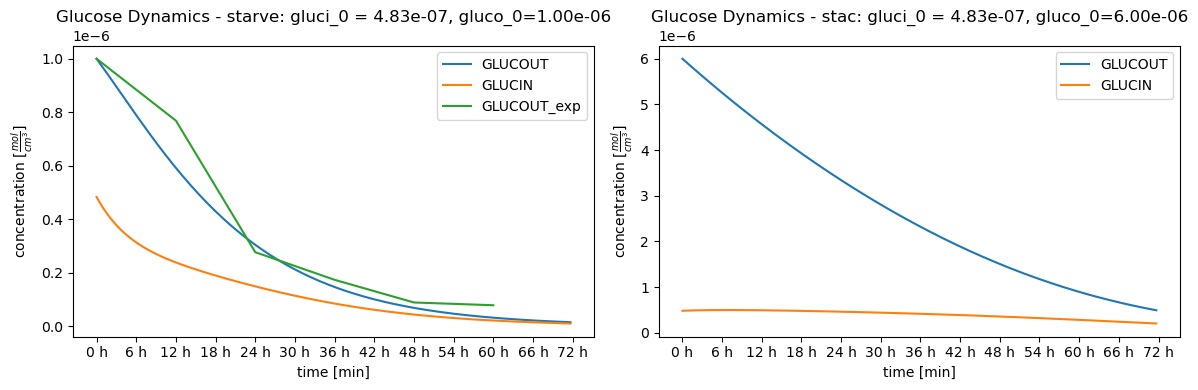

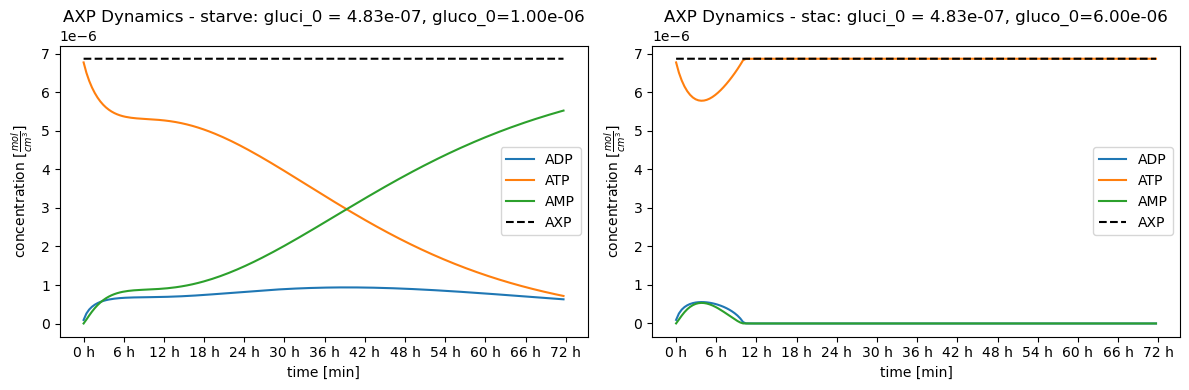

In [233]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if col in ['GLUCIN', 'GLUCOUT']:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    if glucout_0 <= 1e-6:
        ax.plot(sejeong_gluc.t, sejeong_gluc.y, label='GLUCOUT_exp')

    ax.legend()
    ax.set_title(f"Glucose Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if col in ['ATP', 'ADP', 'AMP']:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    all_AXP = data_to_plot_dict[key].ATP + data_to_plot_dict[key].ADP + data_to_plot_dict[key].AMP
    ax.plot(t, all_AXP, 'k--', label='AXP')

    ax.legend()
    ax.set_title(f"AXP Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

plt.tight_layout()
plt.show()

In [206]:
data_to_plot.GLUCIN

1      4.832870e-07
2      4.854030e-07
3      4.873290e-07
4      4.890620e-07
5      4.906110e-07
           ...     
169    2.158550e-07
170    2.129940e-07
171    2.101370e-07
172    2.072810e-07
173    2.044340e-07
Name: GLUCIN, Length: 173, dtype: float64

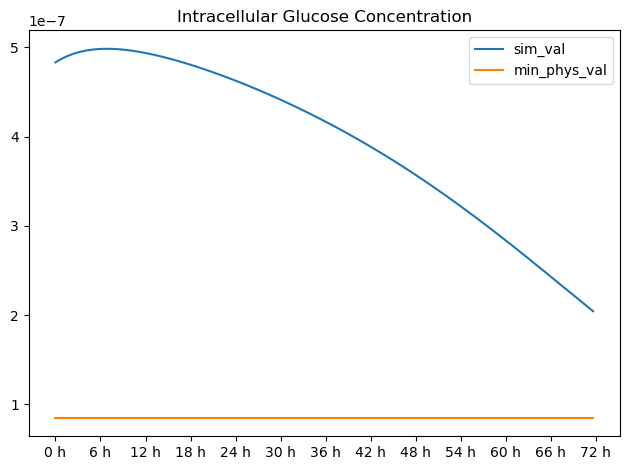

In [229]:
plt.plot(t, data_to_plot.GLUCIN, label='sim_val')
plt.plot(t, np.ones(data_to_plot.GLUCIN.shape)*8.5e-08, label='min_phys_val')
plt.title('Intracellular Glucose Concentration')
plt.legend()
plt.xticks(xticks, xticklabels)
plt.tight_layout()

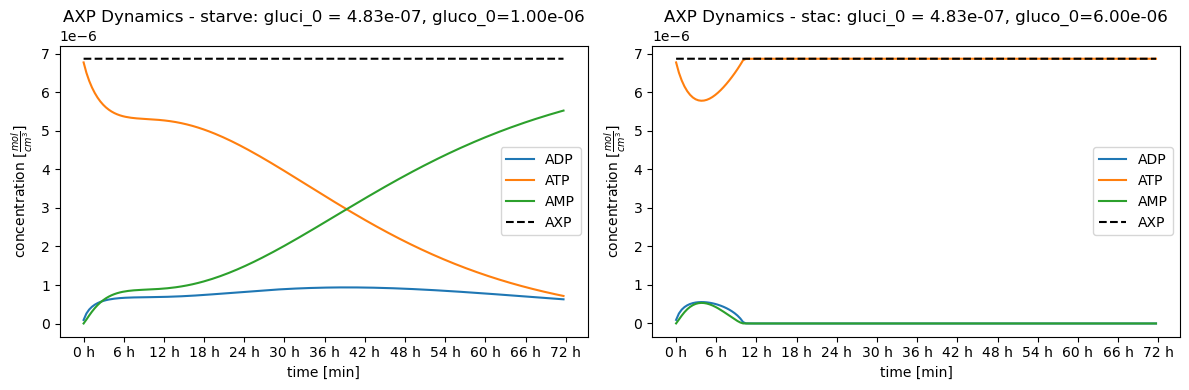

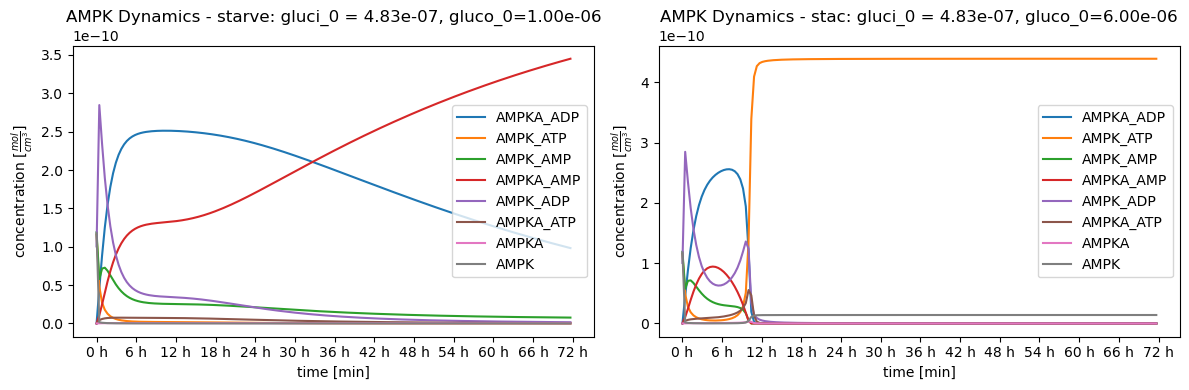

In [234]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if col in ['ATP', 'ADP', 'AMP']:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    all_AXP = data_to_plot_dict[key].ATP + data_to_plot_dict[key].ADP + data_to_plot_dict[key].AMP
    ax.plot(t, all_AXP, 'k--', label='AXP')

    ax.legend()
    ax.set_title(f"AXP Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if 'AMPK' in col and 'LKB1' not in col and 'PP2A' not in col:
            ax.plot(t, data_to_plot_dict[key][col], label=col)

    ax.legend()
    ax.set_title(f"AMPK Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()
plt.show()

- On the left, we can note that the fact that in the beginning ADP-AMPKA is dominant over AMP-AMPK agrees with other in silico models and experiments in active muscle tissue, where it's been shown (coccimiglio et al.) that under physiological levels, ADP is more important in AMPK activation as the cc. of AMP is real low. However, once starvation really begins and AMP cc. skyrockets --> it becomes apparent (in experiments) that AMP is a several fold stronger activator of AMPK than ADP is (this is due to allosteric activation as well as the stabilization of the active AMPK enzyme - this latter is exactly what is achieved by ADP as well)
- On the right, again, AMPK-AMP is not as elevated as AMPK-ADP, bc the cc of ADP is much bigger and thus ADP is the dominant activator of AMPK
## COOL!

In [1]:
data_to_plot_dict = {}
mech_starve = OptimaMechtest(job_name="2025119_testing_starve.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot_dict['starve'] = mech_starve.orig_time_sim_df['starve_0874']
mech_stac = OptimaMechtest(job_name="2025119_testing_stac.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot_dict['stac'] = mech_stac.orig_time_sim_df['stac_0874']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if 'AMPK' in col and 'LKB1' not in col and 'PP2A' not in col:
            ax.plot(t, data_to_plot_dict[key][col], label=col)

    ax.legend()
    ax.set_title(f"Glucose Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if 'MTOR' in col or 'ULK' in col:# or 'ULK' in col or 'TSC' in col or 'RHEB' in col or 'AKT' in col:
            ax.plot(t, data_to_plot_dict[key][col], label=col)

    ax.legend()
    ax.set_title(f"mTOR-ULK Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

plt.tight_layout()
plt.show()

NameError: name 'OptimaMechtest' is not defined

In [253]:
data_to_plot_dict['stac'].MTORA

1      5.310300e-10
2      9.168030e-11
3      2.994830e-11
4      2.994410e-11
5      2.994420e-11
           ...     
169    2.994380e-11
170    2.994380e-11
171    2.994380e-11
172    2.994390e-11
173    2.994390e-11
Name: MTORA, Length: 173, dtype: float64

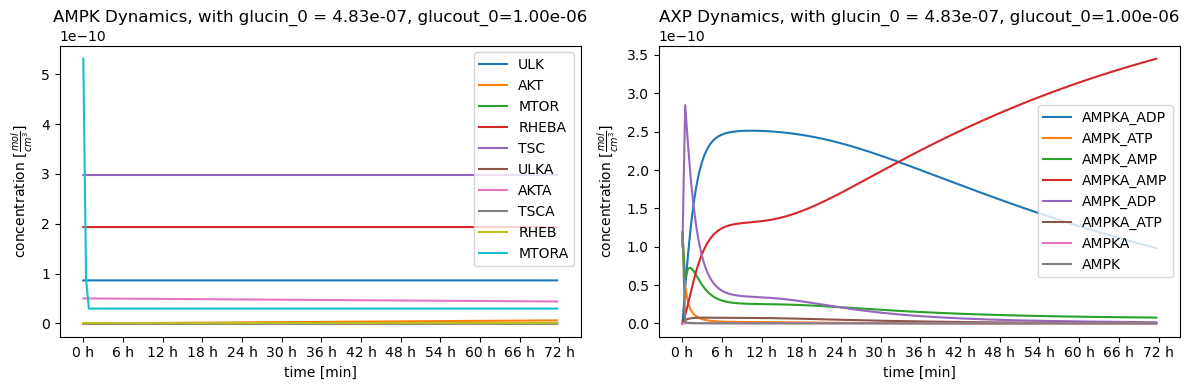

In [220]:
mech_v1 = OptimaMechtest(job_name="2025119_testing_starve.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot = mech_v1.orig_time_sim_df['starve_0874']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax1 = axes[0]
ax2 = axes[1]

glucin_0 = data_to_plot['GLUCIN'].iloc[0]
glucout_0 = data_to_plot['GLUCOUT'].iloc[0]
for col in data_to_plot.columns:
    if 'MTOR' in col or 'ULK' in col or 'TSC' in col or 'RHEB' in col or 'AKT' in col:
        ax1.plot(t, data_to_plot[col], label=col)

ax1.legend()
ax1.set_title(f'AMPK Dynamics, with glucin_0 = {glucin_0:.2e}, glucout_0={glucout_0:.2e}')
ax1.set_xlabel("time [min]")
ax1.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
ax1.set_xticks(xticks, xticklabels)
plt.tight_layout()

for col in data_to_plot.columns:
    if 'AMPK' in col and 'LKB1' not in col and 'PP2A' not in col:
        ax2.plot(t, data_to_plot[col], label=col)

ax2.legend()
ax2.set_title(f"AXP Dynamics, with glucin_0 = {glucin_0:.2e}, glucout_0={glucout_0:.2e}")
ax2.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
ax2.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels)
plt.tight_layout()
plt.show()

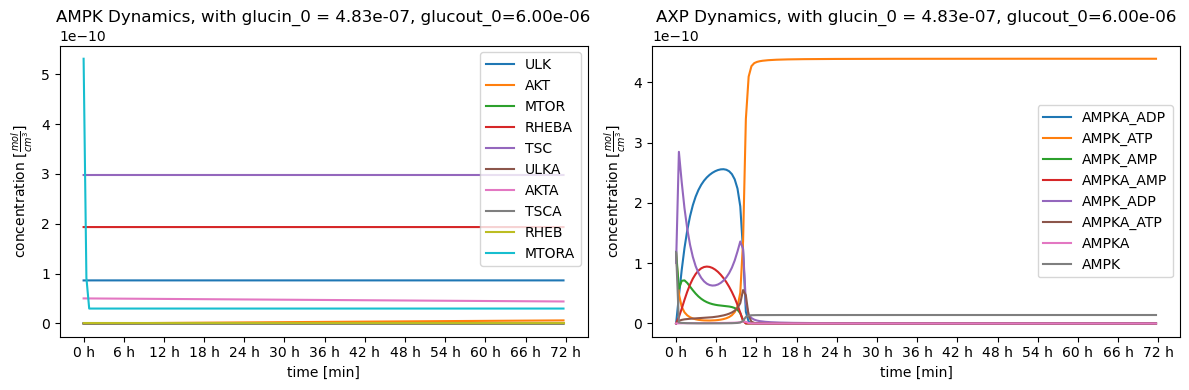

In [223]:
mech_v1 = OptimaMechtest(job_name="2025119_testing_stac.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot = mech_v1.orig_time_sim_df['stac_0874']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax1 = axes[0]
ax2 = axes[1]

glucin_0 = data_to_plot['GLUCIN'].iloc[0]
glucout_0 = data_to_plot['GLUCOUT'].iloc[0]
for col in data_to_plot.columns:
    if 'MTOR' in col or 'ULK' in col or 'TSC' in col or 'RHEB' in col or 'AKT' in col:
        ax1.plot(t, data_to_plot[col], label=col)

ax1.legend()
ax1.set_title(f'AMPK Dynamics, with glucin_0 = {glucin_0:.2e}, glucout_0={glucout_0:.2e}')
ax1.set_xlabel("time [min]")
ax1.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
ax1.set_xticks(xticks, xticklabels)
plt.tight_layout()

for col in data_to_plot.columns:
    if 'AMPK' in col and 'LKB1' not in col and 'PP2A' not in col:
        ax2.plot(t, data_to_plot[col], label=col)

ax2.legend()
ax2.set_title(f"AXP Dynamics, with glucin_0 = {glucin_0:.2e}, glucout_0={glucout_0:.2e}")
ax2.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
ax2.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels)
plt.tight_layout()
plt.show()

In [ ]:
write_inp(species_list=species2,
          out_path='/home/nvme/Opt/7_Krisztian/mech/dummy.inp')

In [29]:
mech_orig = OptimaMechtest(job_name="2025119_stac_starve_rap2.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v0')
data_to_plot_dict['rap_mTOR_orig'] = mech_orig.orig_time_sim_df['stac_0901']

In [30]:
data_to_plot_dict.keys()

dict_keys(['rap_mTOR_v0', 'rap_mTOR_orig'])

In [126]:
mech = OptimaMechtest(job_name='2025119_stac_starve_rap.opp',
                      input_mech='Minimal_gluc_rap_mTOR_v0')

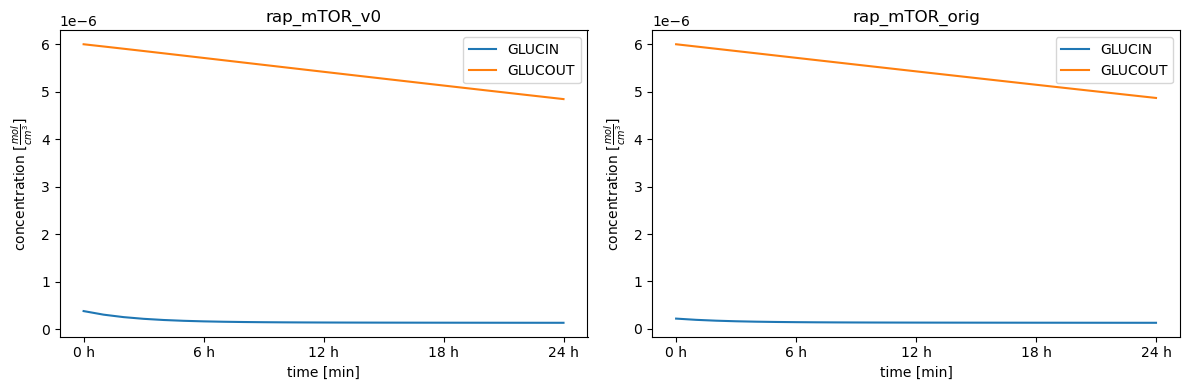

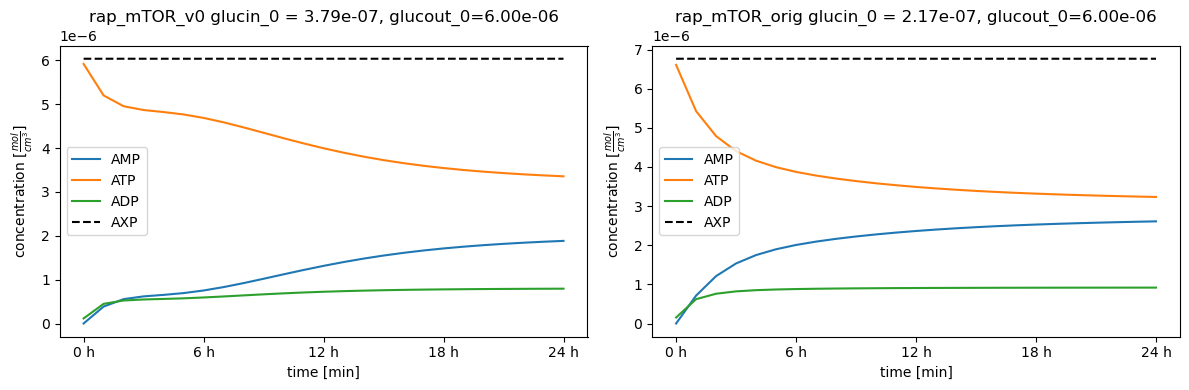

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if col in ['GLUCIN', 'GLUCOUT']:
            ax.plot(t, data_to_plot_dict[key][col], label=col)

    ax.legend()
    ax.set_title(key)
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if col in ['ATP', 'ADP', 'AMP']:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    all_AXP = data_to_plot_dict[key].ATP + data_to_plot_dict[key].ADP + data_to_plot_dict[key].AMP
    ax.plot(t, all_AXP, 'k--', label='AXP')

    ax.legend()
    ax.set_title(f"{key} glucin_0 = {glucin_0:.2e}, glucout_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

plt.tight_layout()
plt.show()


There is no feedback on the AXP module from mTOR activation/inactivation. This is a limitation that will have to be mentioned. It occurs, because we treat the AXPs only as mediators of GLUCOSE input and we do not care about what happens to the AXP pool after they mediated glucose input

rap_mTOR
rap_mTOR_old


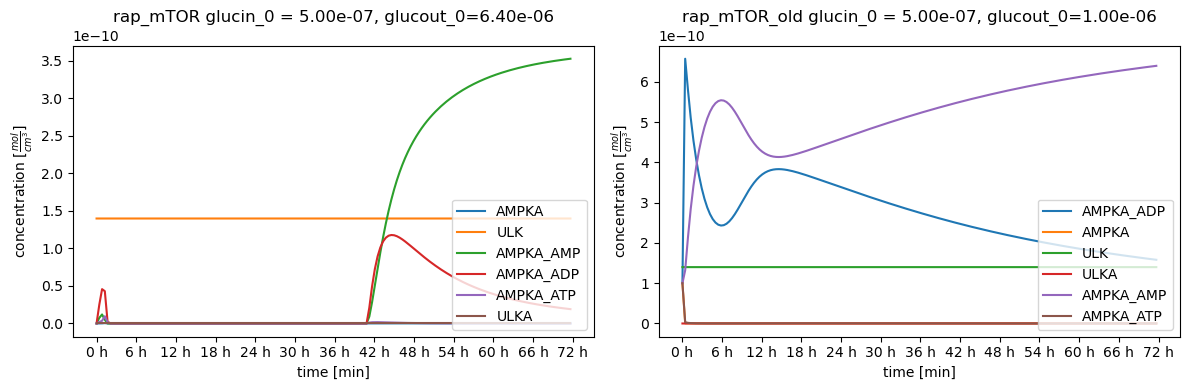

In [260]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    print(key)
    for col in data_to_plot_dict[key].columns:
        if ('ULK' in col or 'AMPKA' in col) and 'LKB1' not in col and 'PP2A' not in col and 'RK' not in col:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    ax.legend(loc='lower right')
    ax.set_title(f"{key} glucin_0 = {data_to_plot_dict[key]['GLUCIN'].iloc[0]:.2e}, glucout_0={data_to_plot_dict[key]['GLUCOUT'].iloc[0]:.2e}")
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()


rap_mTOR
rap_mTOR_old


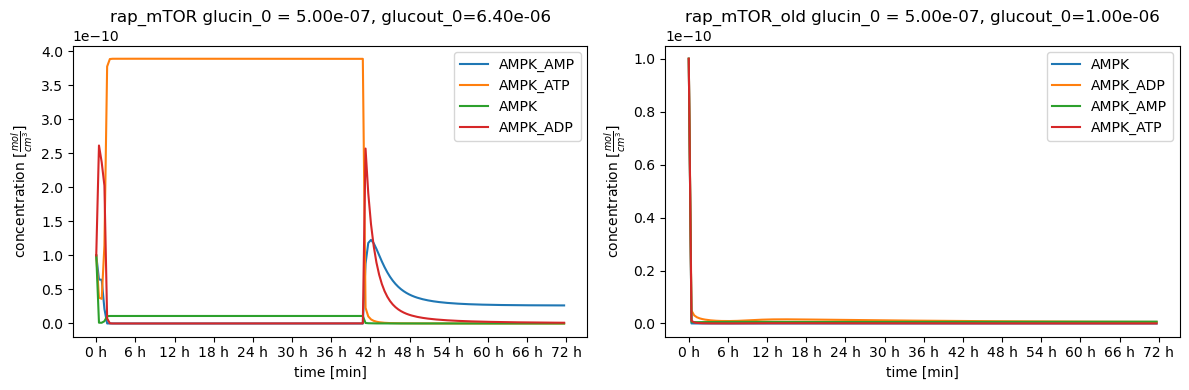

In [261]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    print(key)
    for col in data_to_plot_dict[key].columns:
        if ('AMPK' in col) and 'LKB1' not in col and 'PP2A' not in col and 'RK' not in col and 'AMPKA' not in col:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    ax.legend(loc='upper right')
    ax.set_title(f"{key} glucin_0 = {data_to_plot_dict[key]['GLUCIN'].iloc[0]:.2e}, glucout_0={data_to_plot_dict[key]['GLUCOUT'].iloc[0]:.2e}")
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()


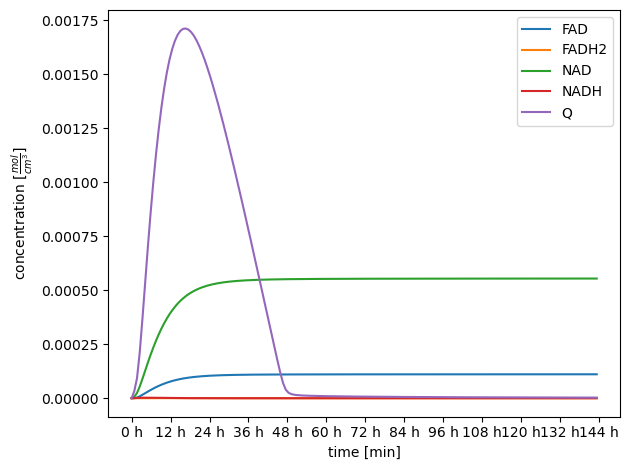

In [65]:
for col in data_to_plot:
    if 'NAD' in col or 'FAD' in col or 'Q' in col:
        plt.plot(t, data_to_plot[col], label=col)
plt.legend()
plt.xlabel(r"time [min]")
plt.ylabel(r"concentration $[\frac{mol}{cm^3}]$")
plt.xticks(xticks, xticklabels)
plt.tight_layout()

In [116]:
mechna = OptimaMechtest(job_name="20251018_starve_transport_clean.opp",
                      input_mech='Minimal_gluc_phos_transport_clean')
to_p = mech.orig_time_sim_df['sejtlegzes_0001']

Text(0.5, 1.0, 'AXP dynamics for glucose = 4.99968e-05')

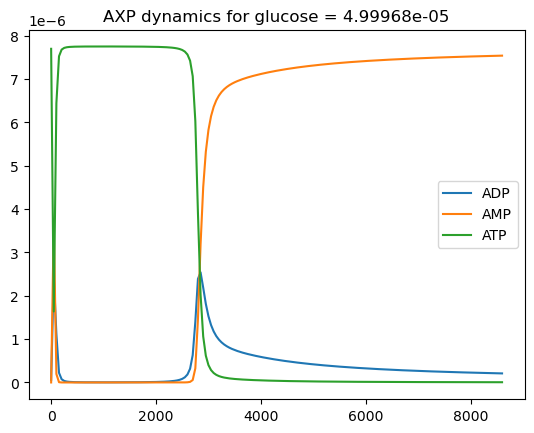

In [118]:
gluc = to_p['GLUCOUT'].iloc[0]
for col in to_p:
    if col in ['ATP', 'ADP', 'AMP']:
        plt.plot(t, to_p[col], label=col)
plt.legend()
plt.title(f'AXP dynamics for glucose = {gluc}')

In [100]:
mech0 = OptimaMechtest(job_name="20251019_starve_transport_GPT.opp",
                      input_mech='Minimal_gluc_phos_transport_GPT')
to_plot = mech0.orig_time_sim_df['starvation_GPT_0001']

In [ ]:
mech0 = OptimaMechtest(job_name="20251011_starve_AXP_dynamics.opp",
                      input_mech='Minimal_gluc_AXP_dynamics')
to_plot = mech0.orig_time_sim_df['starve_AXP_dynamics']

In [107]:
mech0.fine_time_df_dict['starvation_GPT_0001']['t[s]']

0       0.000000e+00
1       2.104438e-11
2       2.104649e-07
3       2.314903e-06
4       6.816131e-06
            ...     
1539    4.647633e+06
1540    4.813568e+06
1541    4.979504e+06
1542    5.145440e+06
1543    5.311376e+06
Name: t[s], Length: 1544, dtype: float64

Text(0.5, 1.0, 'AXP dynamics for glucose = 4.99967e-06')

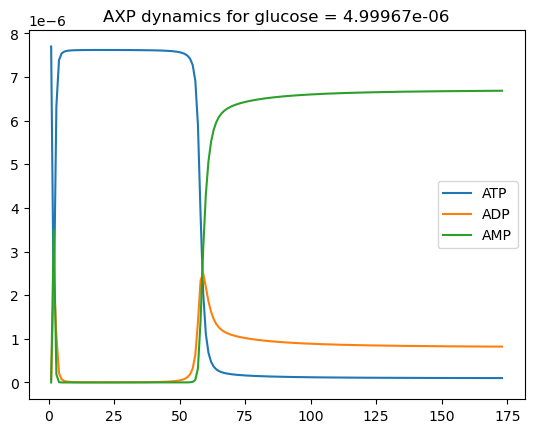

In [ ]:
gluc = to_plot['GLUCIN'].iloc[0]
for col in to_plot:
    if col in ['ATP', 'ADP', 'AMP']:
        plt.plot(t, to_plot[col], label=col)
plt.legend()
plt.title(f'AXP dynamics for glucose = {gluc}')